# Evoluční algoritmy - Genetické programování

Dneska se podíváme na jednoduché genetické programování. Vyzkoušíme si ho na problému symbolické regrese, kdy bude naším cílem nalézt vzoreček, který bude nejlépe odpovídat zadaným datům, a klasifikace, kdy budeme hledat rozhodovací strom pomocí genetického programování.

K tomuto budeme používat knihovnu deap, kterou jsme si ukázali minule.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image

import operator
from deap import gp
from deap import creator, base, tools, algorithms

import pydot
from IPython.display import Image

Nejprve si vygenerujeme data v nějakém rozumném rozsahu a k nim odpovídající labely, například pomocí funkce sinus. Pro ně pak budeme chtít najít vzoreček regrese, který jim bude nejlépe odpovídat.

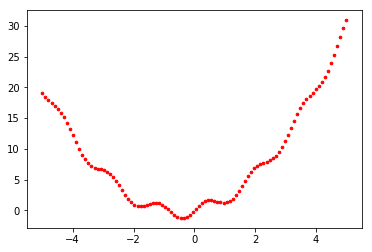

In [12]:
x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.scatter(x_train, y_train,s=7,c='r')
plt.show()

Pro práci s genetickým algoritmem budeme potřebovat vyvořit množinu terminálů a neterminálů, se kterými bude evoluce pracovat. K tomu v knihovně deap existuje třída `gp.PrimitiveSet`, případně `gp.PrimitiveSetTyped` pro typované GP. V našem příkladu použijeme tu typovanou verzi, protože je obecnější. Jelikož ale budeme používat jen jeden typ, šla by použít i netypovaná verze. Jako terminály si definujeme konstanty 0,1,2, zbytek se dovytvoří z nich. Jako neterminály budeme potřebovat operace sčítání, násobení a sinus, a protože zbylé operace se ve vzorečku nevyskytují, nebudeme si jimi zbytečně komplikovat život.

In [16]:
# mnozina se jmenuje MAIN, vstup je jeden float, vystup je taky jeden float
pset = gp.PrimitiveSetTyped('MAIN', [float], float) 

# terminaly
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)

# neterminaly
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
#pset.addPrimitive(operator.sub, [float, float], float)
#pset.addPrimitive(operator.truediv, [float, float], float)

Když máme vytvořené terminály a neterminály, můžeme si definovat jedince, fitness funkci a genetické operátory. Fitness funkce bude MSE (Mean Squared Error), která počítá střední hodnoty druhých mocnin rozdílů mezi predikovanou výstupní hodnotou a skutečnou výstupní hodnotou.

In [17]:
# definujeme fitness 
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # vytvorime funkci podle jedince
    vals = list(map(func, x)) # zavolame funkci na data
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind) #spocitame chybu pomoci MSE

# vytvorime tridy pro jedince
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# limity na hloubku stromu
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

C:\Users\katie\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\katie\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Nyní jsme si napsali všechny potřebné operátory a definovali jsme si populaci, tak si ještě dodefinujeme nějaké statistické metody, abychom mohli sledovat vývoj evoluce a pak můžeme náš algoritmus pro GP pustit.

In [18]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                          fitness                          	                      size                     
   	      	-----------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max        	min    	nevals	std        	avg   	gen	max 	min	nevals	std    
0  	1000  	916861	0  	8.75961e+08	21.2005	1000  	2.77077e+07	90.877	0  	1136	4  	1000  	155.894
1  	576   	114.426	1  	724.867    	12.2255	576   	31.1759    	48.114	1  	729 	2  	576   	84.0628
2  	524   	105.708	2  	556.913    	7.03293	524   	32.0377    	38.205	2  	738 	2  	524   	70.3453
3  	604   	99.4805	3  	3064.72    	7.03293	604   	108.297    	34.686	3  	731 	2  	604   	50.6858
4  	573   	83.5172	4  	1202.33    	7.03293	573   	70.8667    	34.151	4  	291 	2  	573   	31.3572
5  	532   	93.7051	5  	28649.5    	7.03293	532   	906.398    	35.62 	5  	152 	2  	532   	31.1642
6  	540   	51.6148	6  	1601.63    	7.03293	540   	76.3911    	37.137	6  	144 	3  	540

79 	555   	14.6213	79 	499.993    	0.985083   	555   	34.8068    	40.047	79 	87  	3  	555   	10.29  
80 	525   	13.5048	80 	475.816    	0.985083   	525   	33.1834    	40.607	80 	90  	4  	525   	10.536 
81 	534   	12.8368	81 	303.927    	0.985083   	534   	27.8041    	40.899	81 	92  	5  	534   	10.2977
82 	541   	13.9985	82 	545.675    	0.985083   	541   	36.8726    	40.428	82 	80  	3  	541   	9.44822
83 	581   	15.656 	83 	973.629    	0.985083   	581   	45.5966    	40.5  	83 	85  	5  	581   	10.1229
84 	600   	16.0605	84 	499.847    	0.985083   	600   	37.925     	40.262	84 	86  	3  	600   	10.7299
85 	487   	14.1096	85 	474.215    	0.985083   	487   	36.4905    	40.723	85 	80  	4  	487   	9.86865
86 	572   	14.9609	86 	497.504    	0.985083   	572   	34.7065    	40.667	86 	89  	5  	572   	9.95822
87 	543   	12.9647	87 	235.009    	0.985083   	543   	26.3746    	40.912	87 	89  	4  	543   	10.4633
88 	530   	13.1916	88 	579.472    	0.942178   	530   	35.2686    	41.127	88 	80  	3  	530  

Vidíme, že výstu výše je sice krásný a dostatečně vypovídající, ale asi bychom víc ocenili nějakou vizualici. Proto si napíšeme pomocnou funkci na zobrazení vytvořeného stromu. To uděláme pomocí knihovny *pydot*, která slouží právě ke zobrazování grafů.

In [26]:
# zobrazeni jedince jako stromu
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

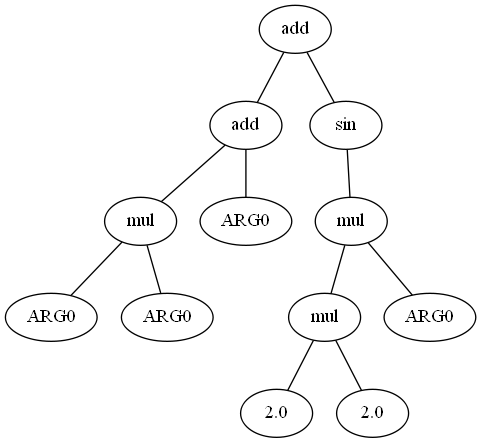

In [33]:
Image(plot_tree(hof[0]))

Ještě si napíšeme jednoduchou funkci, která nám vykreslí graf, abychom se mohli podívat, jak vypadá naše naučená funkce vzhledem k datům.

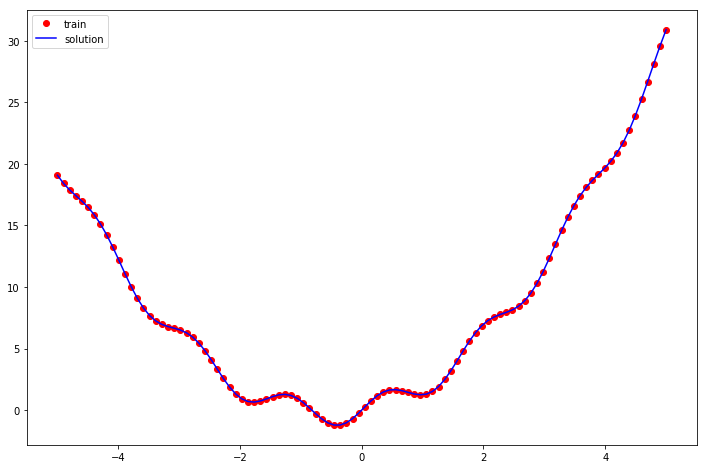

In [46]:
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'ro', label='train')
plt.plot(x_train, y, 'b',label='solution')
plt.legend()
plt.show()

## Úkol na cvičení

Zkuste pomocí genetického programování řešit problém klasifikace, např. pro dataset Iris, se kterým jsme pracovali na prvním cvičení. Promyslete si, jak definovat množinu primitiv a fitness. Následně je naimplementujte je a pusťte genetické programování.